<a href="https://colab.research.google.com/github/tanyagadwal/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from wordcloud import WordCloud

from sklearn import svm
from sklearn.svm import SVC

import lightgbm as lgb
from lightgbm import LGBMClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [164]:
train_set = pd.read_csv("train.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

test_set = pd.read_csv("test.csv",
                   encoding = "utf-8",
                   engine = "python",
                   header = 0)

print("\Datasets were successfully loaded")

\Datasets were successfully loaded


In [165]:
train_set.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [166]:
test_set.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [167]:
print("Training data shape", train_set.shape)
print("Testing data shape", test_set.shape)

Training data shape (31962, 3)
Testing data shape (17197, 2)


In [168]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [169]:
train_set.duplicated().sum()

0

In [170]:
train_set.isna().sum().sum()

0

In [171]:
train_set.groupby("label").count()


,id,tweet
label,,
0,29720,29720
1,2242,2242


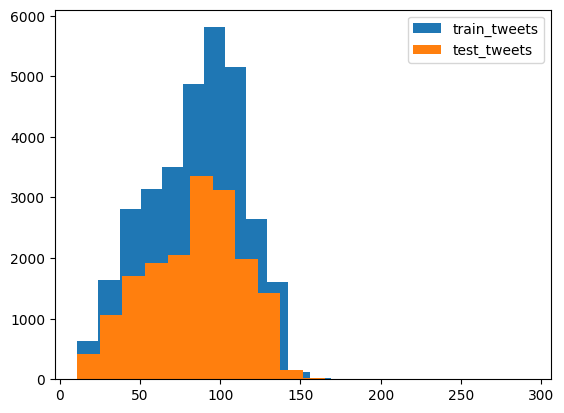

In [172]:
length_train = train_set['tweet'].str.len()
length_test = test_set['tweet'].str.len()
plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

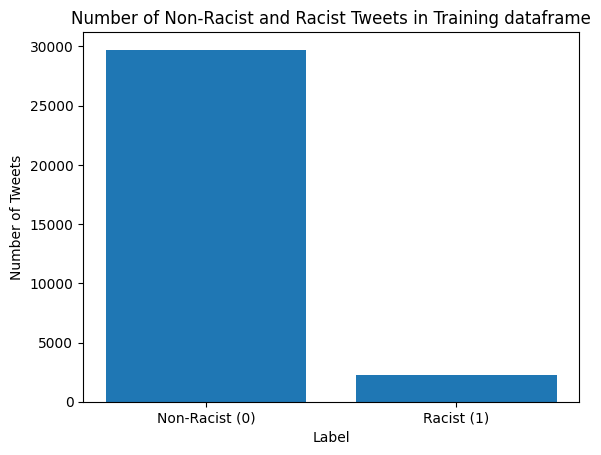

In [173]:
label_counts = train_set['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.title('Number of Non-Racist and Racist Tweets in Training dataframe')
plt.xticks(label_counts.index, ['Non-Racist (0)', 'Racist (1)'])
plt.show()

In [174]:
test_set.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


### Data cleaning

In [175]:
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet" ]= test_set['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [176]:
train_set.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation


In [177]:
test_set.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to se...
2,31965,safe ways to heal your #acne!! #altwaystoheal ...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew e..."


In [178]:
train_set['tweet'] = train_set['tweet'].str.replace("[^a-zA-Z#]", " ")
test_set['tweet'] = test_set['tweet'].str.replace("[^a-zA-Z#]", " ")

In [179]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

train_set['tweet'] = np.vectorize(remove_pattern)(train_set['tweet'], "user*")
test_set['tweet'] = np.vectorize(remove_pattern)(test_set['tweet'], "user*")


In [180]:
train_set.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for #lyft credit i can t ca they d...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ur...
4,5,0,factsguide society now #motivation


In [181]:
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')


In [182]:
stw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stw))

In [183]:
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [184]:
!pip install emoji
train_set['tweet'] = train_set['tweet'].apply(lambda s: emoji.replace_emoji(s, ''))
test_set['tweet'] = test_set['tweet'].apply(lambda s: emoji.replace_emoji(s, ''))

In [185]:
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)
train_set.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks #lyft credit ca offer wheelchair van pd...
2,0,bihday majesty
3,0,#model love u take u time ur
4,0,factsguide society #motivation


In [186]:
test_set.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,#white #supremacists want everyone see new #bi...
2,safe way heal #acne #altwaystoheal #healthy #h...
3,hp cursed child book reservation already yes #...
4,rd #bihday amazing hilarious #nephew eli ahmir...


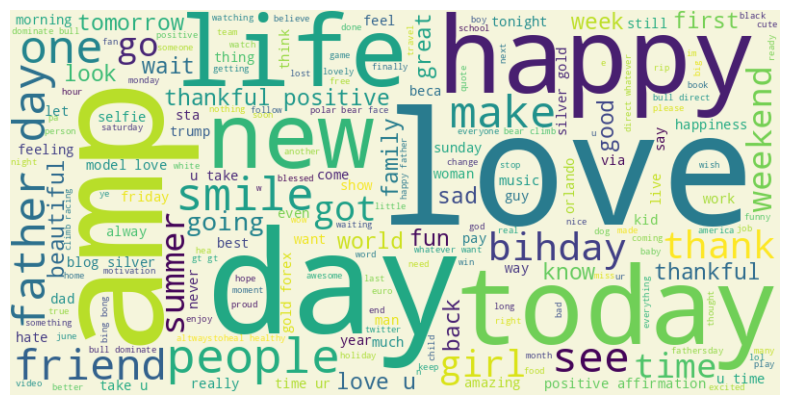

In [187]:
text_train = ' '.join(train_set['tweet'])

wordcloud_train = WordCloud(width=800, height=400, background_color='beige').generate(text_train)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.show()

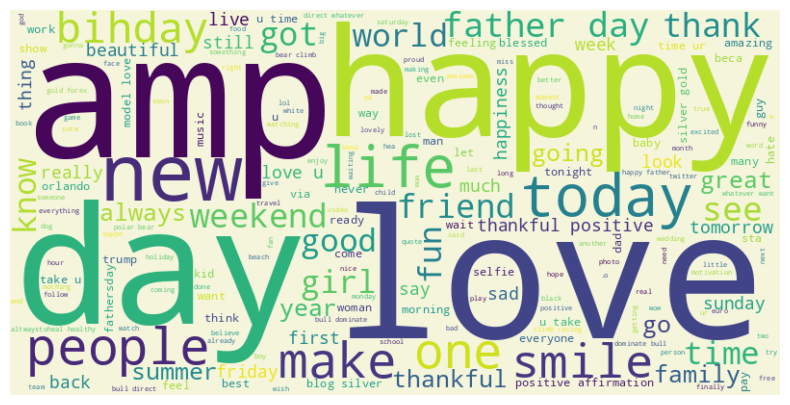

In [188]:
text_test = ' '.join(test_set['tweet'])

wordcloud_test = WordCloud(width=800, height=400, background_color='beige').generate(text_test)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.axis('off')
plt.show()

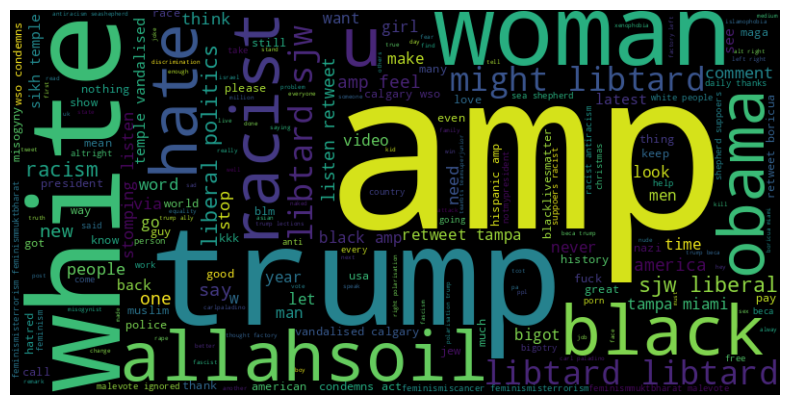

In [189]:
negative_words = ' '.join([text for text in train_set['tweet'][train_set['label'] == 1]])
wordcloud = WordCloud(width=800, height=400).generate(negative_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [190]:
tokenized = train_set['tweet'].apply(lambda x: x.split())
tokenized.head()

0    [father, dysfunctional, selfish, drag, kid, dy...
1    [thanks, #lyft, credit, ca, offer, wheelchair,...
2                                    [bihday, majesty]
3                 [#model, love, u, take, u, time, ur]
4                   [factsguide, society, #motivation]
Name: tweet, dtype: object

## Splitting data into training and testing

In [191]:
X = train_set['tweet']
y = train_set['label']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 11)

In [192]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)

X_train_count.toarray()
X_test_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [193]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train)

X_train_tfidf = tf_idf_word_vectorizer.transform(X_train)
X_test_tfidf = tf_idf_word_vectorizer.transform(X_test)

X_train_tfidf.toarray()
X_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Logistic Regression

In [194]:
lr = linear_model.LogisticRegression()
log_model = lr.fit(X_train_count, y_train)
y_pred = lr.predict(X_test_count)
accuracy_score(y_test, y_pred)



0.9583919912404192

In [195]:
accuracy = model_selection.cross_val_score(log_model, X_test_count, y_test, cv = 20).mean()
print("\nLogistic regression model with 'count-vectors' method")
print("Accuracy ratio: ", accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9479134012539185


In [196]:
f1_score(y_test, y_pred)

0.6443850267379679

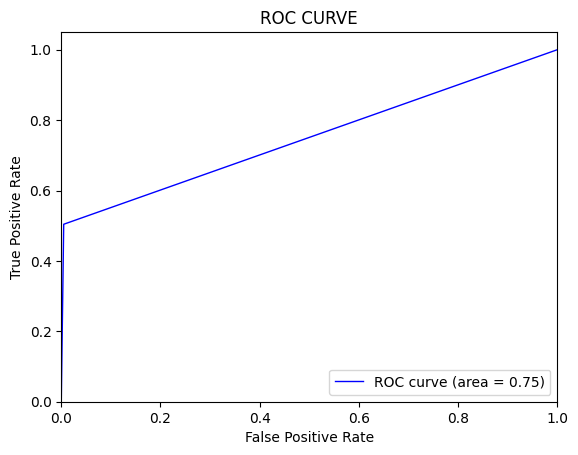

In [197]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [198]:
print("Number of mislabeled points out of a total of", X_test.size, "points : ", (y_test != y_pred).sum())

Number of mislabeled points out of a total of 6393 points :  266


In [199]:
log_model2 = lr.fit(X_train_tfidf, y_train)
y_pred2 = lr.predict(X_test_tfidf)
accuracy_score(y_test, y_pred2)

0.9452526200531832

In [200]:
accuracy = model_selection.cross_val_score(log_model2, X_test_tfidf, y_test, cv = 20).mean()
print("\nLogistic regression model with 'tf-idf' method")
print("Accuracy ratio: ", accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9310197884012539


In [201]:
f1_score(y_test, y_pred2)

0.44267515923566875

In [202]:
print("Number of mislabeled points out of a total of", X_test.size, "points : ", (y_test != y_pred2).sum())

Number of mislabeled points out of a total of 6393 points :  350


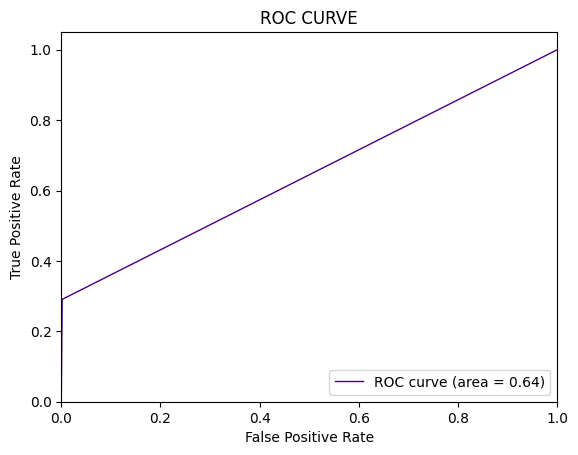

In [203]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Support Vector Machine

In [204]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_count, y_train)
y_pred_svm = clf.predict(X_test_count)
accuracy_score(y_test, y_pred_svm)

0.9621460972939152

In [205]:
f1_score(y_test, y_pred_svm)

0.7132701421800947

In [206]:
print("Number of mislabeled points out of a total of", X_test.size, "points : ", (y_test != y_pred_svm).sum())

Number of mislabeled points out of a total of 6393 points :  242


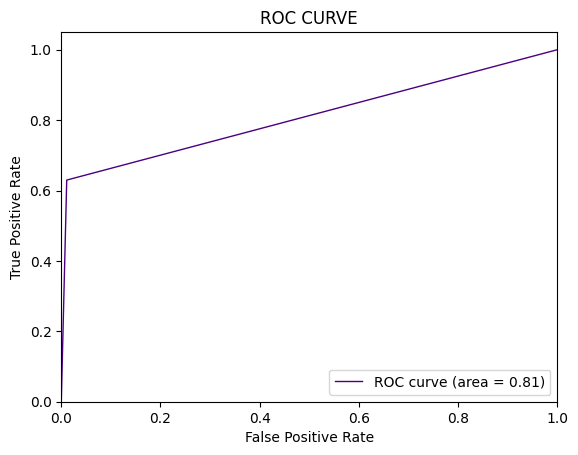

In [207]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [208]:
clf.fit(X_train_tfidf, y_train)
y_pred_svm2 = clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_svm2)

0.9615204129516659

In [209]:
f1_score(y_test, y_pred_svm2)

0.6737400530503979

In [210]:
print("Number of mislabeled points out of a total of", X_test.size, "points : ", (y_test != y_pred_svm2).sum())

Number of mislabeled points out of a total of 6393 points :  246


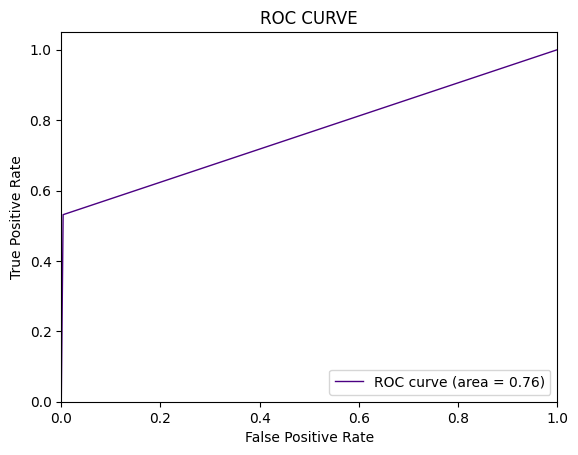

In [211]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Light GBM

In [212]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(X_train_count.astype("float64"), y_train)
y_pred_lgb = lgbm.predict(X_test_count.astype("float64"))
accuracy_score(y_test, y_pred_lgb)


0.9491631471922415

In [213]:
accuracy = model_selection.cross_val_score(lgbm_model, X_test_count.astype("float64"), y_test, cv = 20).mean()
print("Light GBM model with 'count-vectors' method")
print("Accuracy ratio: ", accuracy)

Light GBM model with 'count-vectors' method
Accuracy ratio:  0.9394680642633227


In [214]:
f1_score(y_test, y_pred_lgb)

0.5350500715307582

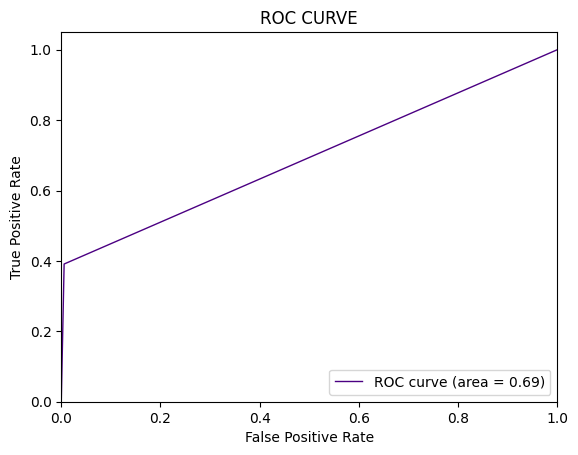

In [215]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Alternately,

In [216]:
d_train=lgb.Dataset(X_train_count.astype("float64"), label=y_train)
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['max_depth']=15
params['num_leaves'] = 9
params['max_depth'] = 10
clf_lgb=lgb.train(params,d_train)
y_pred_lgb2=clf_lgb.predict(X_test_count.astype("float64"))
for i in range(0,X_test.size):
    if y_pred_lgb2[i]>=.5:
       y_pred_lgb2[i]=1
    else:
       y_pred_lgb2[i]=0

accuracy_score(y_test, y_pred_lgb2)

[LightGBM] [Info] Number of positive: 1764, number of negative: 23805
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.372337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3941
[LightGBM] [Info] Number of data points in the train set: 25569, number of used features: 1473
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068990 -> initscore=-2.602312
[LightGBM] [Info] Start training from score -2.602312


0.9380572501173158

In [217]:
f1_score(y_test, y_pred_lgb2)

0.32881355932203393

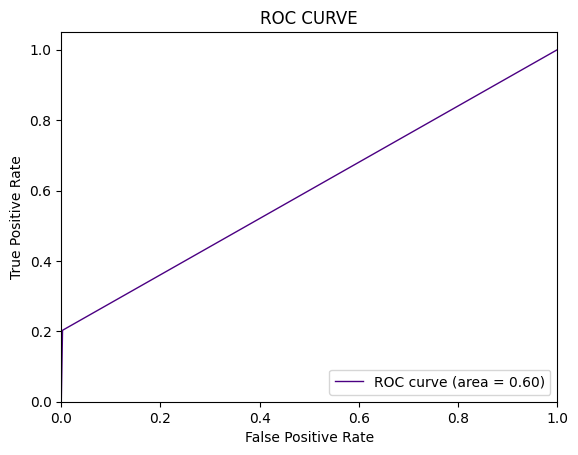

In [218]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [219]:
print("Number of mislabeled points out of a total of", X_test.size, "points : ", (y_test != y_pred_lgb2).sum())

Number of mislabeled points out of a total of 6393 points :  396
